<a href="https://colab.research.google.com/github/miskin1991/SoftUni-Cpp-May-2023-Advanced/blob/main/cnn_model_mobilnet_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check which python3 instance is used in the environment
!which python3
!which pip3

/usr/bin/python3
/usr/local/bin/pip3


# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import json
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Cat vs Dog classification project

## Introduction

This project focuses on build and evaluate machine learning models for image classification. This is a fundamental task in computer vision, and distinguishing between cats and dogs is a classic example used to demonstrate the effectiveness of various deep learning techniques. We will explore different model architectures and training strategies to achieve accurate classification results.

During this notebook journey, we are going to experiment with Convolutional Neural Networks (CNNs) and closely examine how they are defined. We will try to construct our own models with specific characteristics to predict a class for a given image. In addition, we will use a predefined model that has already been trained on thousands of images, fit it for our own use case and then compare results. Hopefully that exercise will help us understand the importance of dataset sizes, both in amount and diversity directions, for training a model from scratch versus a pre-trained model.

### Why to use a Machine Learninig modeling?

**Machine Learning** (ML) is a powerful technology we use to solve problems by answering a question. To answer a question, we need to create a piece of software called `model` and request it to perform a `prediction` for us. The model by itself is capable to give us an answer, but probably the veracity for the answer received will be poor. It is our task to help the model to improve the quality of the answers, by suppling it with some means to improve the correctness of it's own predictions. To accomplish that task, we need to feed it with a sufficiently large and diverse dataset that can help it to extract valueable `features` and improve it's capabilities. This is a very important part of the training process, also known as `fit`. It helps the model to provide accurate solutions with a reasonable confidence rate.

The **ML** process is categorized in different types, each of them using an input datasets in a different way during the learning process. You can take a look at the followoing [article](https://developers.google.com/machine-learning/intro-to-ml/what-is-ml) for further information about it. During this research we will take the supervised learning approach to fit our model and based our solution on a CNN architecture.

### What is a CNN based model?

A convolutional neural network is a layered network capable to recognize common patterns in an image for objects, classes or categories identification. It is assembled by N internal layers that are hidden from us. Those layers are specialized to identify features in an image, internally classify those and forward them to the following layer for further processing. Thus, we have 3 main class of layers:
* **Input Layer**: this layer is composed by the original data provided to the model. In our use case we consider it as an image that contains a class of interest. The image is used to feed the hidden layer(s) for feature identifications.
* **Hidden Layer(s) (Features)**: this layers are composed by all internal layers dedicated to detect and identify any feature of interest. Thus, it performs detection activating the responsible neurons within the network.
* **Output Layer**: This is the output layer that performs the classification and provides output as a result.

![CNN Layers](https://www.mathworks.com/discovery/convolutional-neural-network/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_792810770_copy.adapt.full.medium.jpg/1745491656387.jpg)

### How a feature is detected?
The CNN hidden layers perform operations that operates the data with a purpose to learn features specifics characteristics. Three of the most common layers in the feature detection mechanism are convolution, activation or Rectified linear unit (ReLU), and pooling.


![Feature Layer](https://www.mathworks.com/discovery/convolutional-neural-network/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_2109075398_cop.adapt.full.medium.jpg/1745491656398.jpg)

* **Convolution**: performs convolution filter on the image which activates certain features from it. The filter, also known as [kernel](https://www.geeksforgeeks.org/deep-learning/types-of-convolution-kernels/), applied to the image scans for patters such as edgest, line and textures.
* **Activation**: also known as activation layer that activates or deactivates a neuron based on a match to a feature and introduce no-linearity. This neuron then is used or not in the next layer to compose a bigger feature or characteristic.
$$ReLU(X)=max(0,x)$$
* **Pooling**: simplifies the output using nonlinear downsampling and reduce the parameters that the network shall train. The goal is to reduce the spatial size (height and width) while keeping the most important features.


Unlike a traditional neural network, a CNN has shared weights and bias values, which are the same for all hidden neurons in a given layer. This means that all hidden neurons are detecting the same feature, such as an edge or a blob, in different regions of the image. This makes the network tolerant to translation of objects in an image. For example, a network trained to recognize cars will be able to do so wherever the car is in the image.

### What is a classification?
After learning features in many layers, the architecture of a CNN shifts to classification. This is done in the output layer, a fully connected layer that outputs a vector of N dimensions (where N is the number of classes able to be predicted) and contains the probabilities for each class of an image being classified. The final layer of the CNN architecture uses a classification layer to provide the final classification output.

## Models

In this section we are going to define our three models for a class classification network. We will define and train a network that shall be able to classify correctly if a given image contains a dog or a cat. For this purpose we are going to fit our model with some training data retrieved from Internet with images that are free of license. You can find more about the datasets used in the [Download section](#downloads) of this document.

### Constants

In [ ]:
# CONSTANTS
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

### Dataset

Load the dataset using TensorFlow Datasets to load the 'cats_vs_dogs' dataset. Split the dataset into training and testing sets. The training set will be 15% of the original dataset, and the test set will be 5%.

In [ ]:
(train_ds_15p, test_ds_5p), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:15%]', 'train[25%:30%]'],
    with_info=True,
    as_supervised=True
)

Additionally let's try to load more data from our dataset in order to compare the fit results later on. So, lets tkat now a set of 50% of the original dataset for training, and a validation set of 20%.

In [ ]:
(train_ds_50p, test_ds_20p), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:50%]', 'train[50%:70%]'],
    with_info=True,
    as_supervised=True
)

The tfds type for dataset load is a `_prefetchDataset` which is not directly support by Keras and cannot be provided directly to the `fit` method. For that reason we need to preprocess the dataset completely changing it to a custom _prefetchDataset but with only `(image, label)` dataset pair.

In [ ]:
def preprocess_image(image, label):
    '''
    Preprocess the image by resizing and normalizing it.
    Args:
        image: The input image tensor.
        label: The label associated with the image.
    Returns:
        A tuple of the preprocessed image and its label.
    '''
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
# Map the preprocessing function to the datasets
train_ds_15p = train_ds_15p.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_15p = train_ds_15p.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_5p = test_ds_5p.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_5p = test_ds_5p.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Map the preprocessing function to the datasets
train_ds_50p = train_ds_50p.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_50p = train_ds_50p.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_20p = test_ds_20p.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_20p = test_ds_20p.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# create output folder
!mkdir -p models
# prepare colab for image plot
%matplotlib inline

### Custom model

First, lets define our `create_model` with the following architecutre characteristics:
1. Input layer: 224x224x3
   1. Add flip layer for data augmentation
   2. Add rotation and zoom layers for data augmentation
2. Hidden layer
   1. Conv2D layer with 32 filters, 3x3 kernel, ReLU activation
   2. MaxPooling2D layer
   3. Conv2D layer with 64 filters, 3x3 kernel, ReLU activation
   4. MaxPooling2D layer
   5. Conv2D layer with 128 filters, 3x3 kernel, ReLU activation
   6. MaxPooling2D layer
3. Output layer:
   1. Flatten layer
   2. Dense layer with 128 units, ReLU activation
   3. Dropout layer with 20% dropout rate
   4. Dense layer with 1 unit, sigmoid activation

In [ ]:
def create_model():
    '''
    Create a simple CNN model for binary classification.
    Returns:
        model: A Keras Sequential model.
    '''
    return models.Sequential([
      layers.Input(shape=(224, 224, 3)),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
      layers.Conv2D(32, (3,3), activation = 'relu', ),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(64,(3,3), activation = 'relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation = 'relu'),
      layers.MaxPooling2D(2,2),
      layers.Flatten(),
      layers.Dense(128, activation ='relu'),
      layers.Dropout(0.2),
      layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
def draw_history(history_file_path):
    '''
    Draw the training history from a JSON file.
    Args:
        history_file: Path to the JSON file containing training history.
    '''
    with open(history_file_path, 'r') as f:
        history = json.load(f)

    # plot the training history
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.grid(True)
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.title('Validation History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.grid(True)
    plt.legend(loc='best')

In [ ]:
def print_model_summary(model_path):
    '''
    Print the summary of the model.
    Args:
        model: The Keras model to summarize.
    '''
    model = tf.keras.models.load_model(model_path)
    print(model.summary())

### Pre-trained model

Now lets define as well our `create_pretrained_model` based on the **MobileNetV2** model that instantiates a MobileNet CNN architecture. We are going to use the `MobileNetV2` constructor to create a pre-trained base model. It is already trained and preserves the preconfigured values for weights and biases, and we are going to mantain them and just refine the last layer for custom classification process according to our usecase. For further information you can reach out the `Keras` documentation.

In [ ]:
def create_pretrained_model():
    '''
    Create a pre-trained model using MobileNetV2 for binary classification.
    Returns:
        model: A Keras Sequential model.
    '''
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    return models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

### Models fit

First, lets define our custom fit function so we can fit both models in the same way. With the following function we are going to train all 3 models defined previously. With this technique, we ensure that all of them are fit with the same configuration parameters as mantain our focus on the result comparison.

In [ ]:
def train_and_safe_model(train_ds, test_ds, model_name, model_fn):
    '''
    Train the model and save it to a JSON file.
    Args:
        train_ds: training dataset.
        test_ds: validation dataset.
        model_name: The name of the model to save.
        model_fn: fit function
    '''
    model = model_fn()
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

    # safe current model
    model.save(f'models/{model_name}.keras')
    # save the training history
    with open(f'models/{model_name}_history.json', 'w') as f:
        json.dump(history.history, f)

## Training


### Model training with 15% of dataset

In [ ]:
train_and_safe_model(train_ds=train_ds_15p, test_ds=test_ds_5p, model_name='cats_vs_dogs_classifier_15p', model_fn=create_model)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5081 - loss: 0.8453 - val_accuracy: 0.6053 - val_loss: 0.6696
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5917 - loss: 0.6744 - val_accuracy: 0.6294 - val_loss: 0.6422
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5879 - loss: 0.6751 - val_accuracy: 0.6268 - val_loss: 0.6555
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6126 - loss: 0.6648 - val_accuracy: 0.6337 - val_loss: 0.6590
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.6239 - loss: 0.6554 - val_accuracy: 0.6604 - val_loss: 0.6408
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.6441 - loss: 0.6435 - val_accuracy: 0.6543 - val_loss: 0.6364
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.6315 - loss: 0.6425 - val_accuracy: 0.6483 - val_loss: 0.6297
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6472 - loss: 0.6304 - va

In [ ]:
print_model_summary("models/cats_vs_dogs_classifier_15p.keras")

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_9 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

None


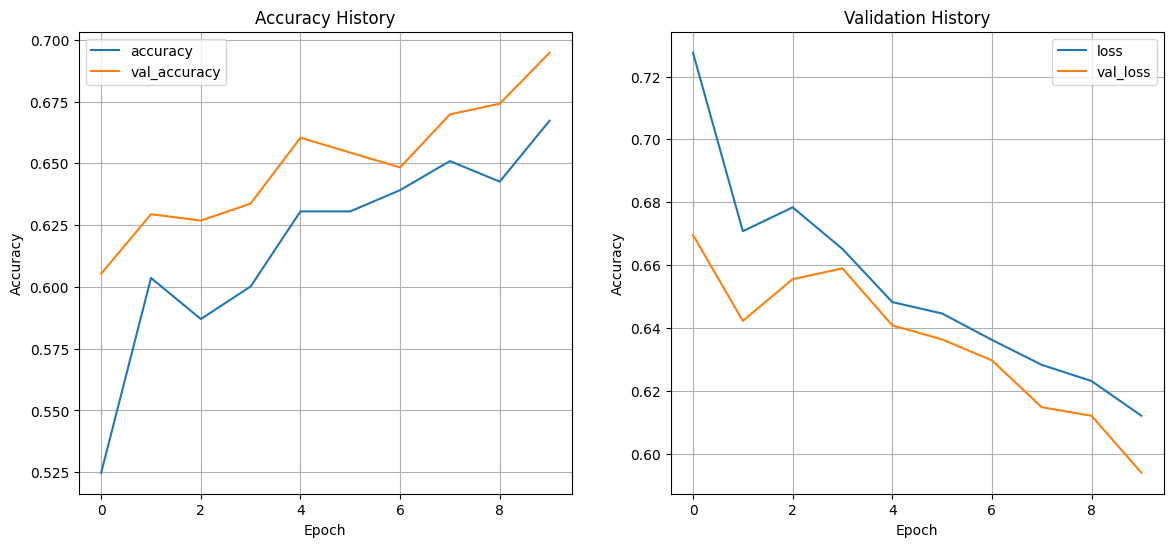

In [ ]:
draw_history("models/cats_vs_dogs_classifier_15p_history.json")

### Model training with 50% of dataset

In [ ]:
train_and_safe_model(train_ds=train_ds_50p, test_ds=test_ds_20p, model_name='cats_vs_dogs_classifier_50p', model_fn=create_model)

Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5774 - loss: 0.6948 - val_accuracy: 0.6924 - val_loss: 0.5935
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.6842 - loss: 0.5954 - val_accuracy: 0.7085 - val_loss: 0.5610
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.7098 - loss: 0.5590 - val_accuracy: 0.7590 - val_loss: 0.4967
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.7519 - loss: 0.5051 - val_accuracy: 0.7706 - val_loss: 0.4818
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7642 - loss: 0.4868 - val_accuracy: 0.7792 - val_loss: 0.4626
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.7758 - loss: 0.4710 - val_accuracy: 0.8027 - val_loss: 0.4332
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.7938 - loss: 0.4460 - val_accuracy: 0.8207 - val_loss: 0.4033
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7979 - loss: 0.4305 - 

In [ ]:
print_model_summary("models/cats_vs_dogs_classifier_50p.keras")

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_10              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_10 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

None


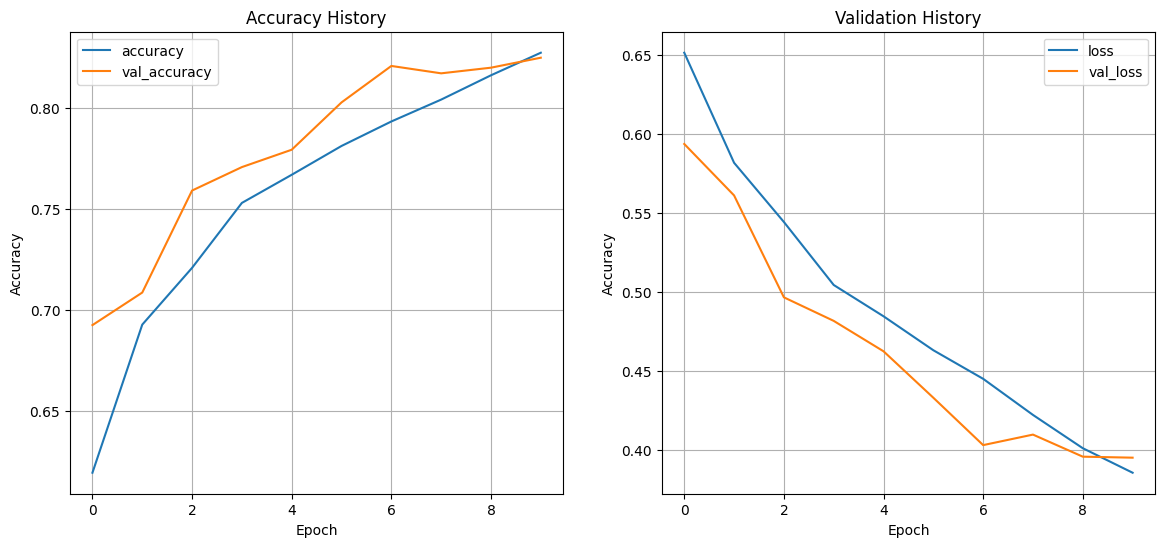

In [ ]:
draw_history("models/cats_vs_dogs_classifier_50p_history.json")

### Pretrained model training with 15% of dataset

In [ ]:
train_and_safe_model(train_ds=train_ds_15p, test_ds=test_ds_5p, model_name='cats_vs_dogs_classifier_15p_mobilnet', model_fn=create_pretrained_model)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.9121 - loss: 0.2100 - val_accuracy: 0.9759 - val_loss: 0.0711
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9771 - loss: 0.0698 - val_accuracy: 0.9759 - val_loss: 0.0657
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9832 - loss: 0.0585 - val_accuracy: 0.9733 - val_loss: 0.0710
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9872 - loss: 0.0408 - val_accuracy: 0.9759 - val_loss: 0.0766
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9868 - loss: 0.0396 - val_accuracy: 0.9854 - val_loss: 0.0441
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9918 - loss: 0.0303 - val_accuracy: 0.9828 - val_loss: 0.0490
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9915 - loss: 0.0238 - val_accuracy: 0.9811 - val_loss: 0.0572
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9949 - loss: 0.0171 - val

In [ ]:
print_model_summary("models/cats_vs_dogs_classifier_15p_mobilnet.keras")

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

None


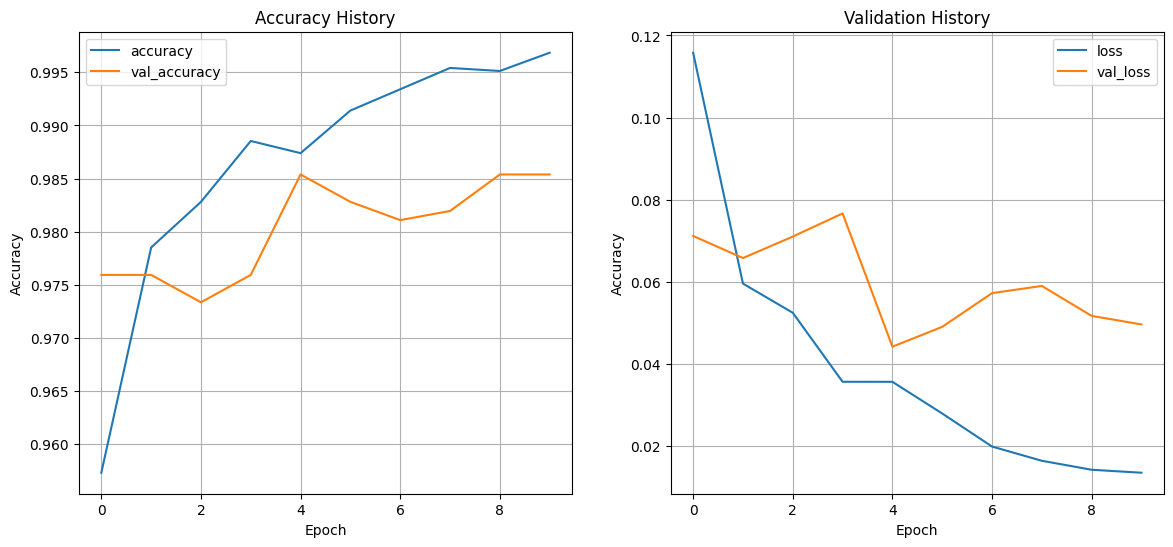

In [ ]:
draw_history("models/cats_vs_dogs_classifier_15p_mobilnet_history.json")

## Training analysis

In this section we are going to make a comparison between the 3 models results in order to assess how the training session went. Let's try to identify if it is possible for our models to provide meaningful and veracity results after the fit task. For this reason let's plot first the accuracy metrics for all of them and analyse it.

In [ ]:
def retrieve_metrics(path, metric):
  '''
  Retrieve a metric value from a history file
  Args:
    path: history file path
    metric: metric type
  Returns:
    metrics: list of metrics
  '''
  with open(path, 'r') as f:
    history = json.load(f)

  return history[metric]

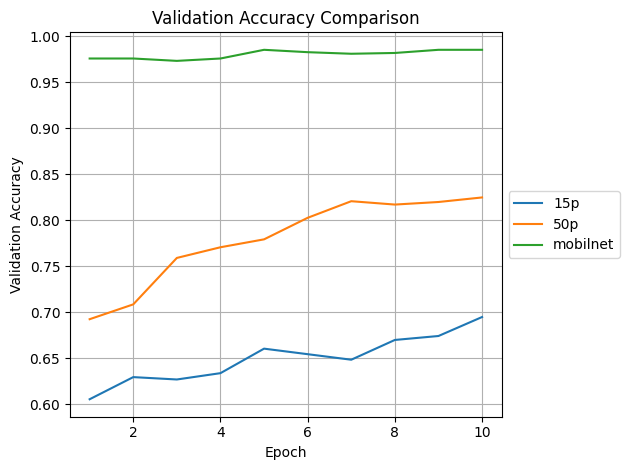

In [ ]:
val_accuracies = []

val_accuracies.append(retrieve_metrics("models/cats_vs_dogs_classifier_15p_history.json", "val_accuracy"))
val_accuracies.append(retrieve_metrics("models/cats_vs_dogs_classifier_50p_history.json", "val_accuracy"))
val_accuracies.append(retrieve_metrics("models/cats_vs_dogs_classifier_15p_mobilnet_history.json", "val_accuracy"))

labels = ["15p", "50p", "mobilnet"]

for acc, label in zip(val_accuracies, labels):
    plt.plot(range(1, len(acc)+1), acc, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjusts plot so nothing is cut off
plt.show()

What we can evidence from this 'Validation Accuracy Comparison' diagram it is clear that there are at least 2 primary reasons that affect to the models accuracy.

First, we can see that in the `15p` and `50p` own models, we have similar learning curve but both starting point and ending point differs with 10-15 points of a percentil. This can give us a solid base to determine how important is to have a big image dataset to train a model and consequently to achieve quality in the responses. The dataset quantity not only helps to reach better accuracy metrics, but also contribuites to improve the gradient curve for each epoch.

The second points we can see, if we take the `mobilnet` accuracy output, is that the accuracy has a strong flat pattern, in this scale, which points how a pretrained model can learn way faster, just in 1 or 2 epochs. It support and clasify new information and there is not any benefit at all to train it during a considerable amount of epochs. Additionally it is also not required to use a larger datasets to obtain a quality performance for this specific classification task.

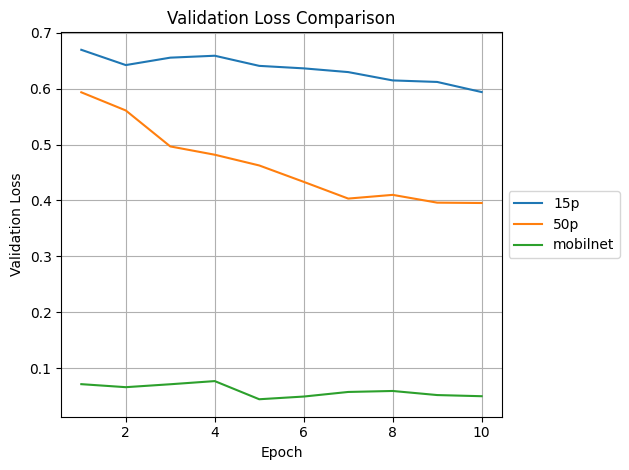

In [ ]:
val_loss = []

val_loss.append(retrieve_metrics("models/cats_vs_dogs_classifier_15p_history.json", "val_loss"))
val_loss.append(retrieve_metrics("models/cats_vs_dogs_classifier_50p_history.json", "val_loss"))
val_loss.append(retrieve_metrics("models/cats_vs_dogs_classifier_15p_mobilnet_history.json", "val_loss"))

labels = ["15p", "50p", "mobilnet"]

for acc, label in zip(val_loss, labels):
    plt.plot(range(1, len(acc)+1), acc, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjusts plot so nothing is cut off
plt.show()

And finally, what we can conclude from this 'Validation Loss Comparison' diagram that is just a pure validation of what we detected previously. In summary, we can say that there is a strong dependency between the confidence of a model to classify correctly a class and the dataset used to stimulate it.

## Predictions

In [ ]:
# predict
def predict_image(model, img_array):
    '''
    Predict the class of an image.
    Args:
        model: The trained Keras model.
        img_path (str): Path to the image file.
    Returns:
        The predicted class of the image.
    '''
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    if predictions[0] > 0.5:
        return (f"Dog ({int(predictions[0][0] * 100)}%)")
    else:
        return (f"Cat ({int((1.0 - predictions[0][0]) * 100)}%)")

In [ ]:
def predict(model):
  '''
  Predict a set of an images.
  Args:
      model: The trained Keras model.
  '''
  model = tf.keras.models.load_model(model)

  validation_ds, metadata = tfds.load(
      'cats_vs_dogs',
      split='train[99%:]',
      with_info=True,
      as_supervised=True
  )

  validation_ds = validation_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
  validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  IMAGES_NUM = 6  # Number of images to display
  # Get a batch of BATCH_SIZE images from the validation dataset
  for images, labels in validation_ds.unbatch().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).take(1):
      images = images[:IMAGES_NUM]
      labels = labels[:IMAGES_NUM]
      plt.figure(figsize=(IMAGES_NUM * 2, IMAGES_NUM))
      for i in range(IMAGES_NUM):
          img_array = images[i].numpy()
          plt.subplot(2, 3, i + 1)
          plt.imshow(img_array)
          plt.title(f"Label: {'Dog' if labels[i].numpy() == 1 else 'Cat'}\nPredicted: {predict_image(model, img_array)}")
          plt.axis('off')
      plt.tight_layout()
      plt.show()

### Model prediction with 15% of dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


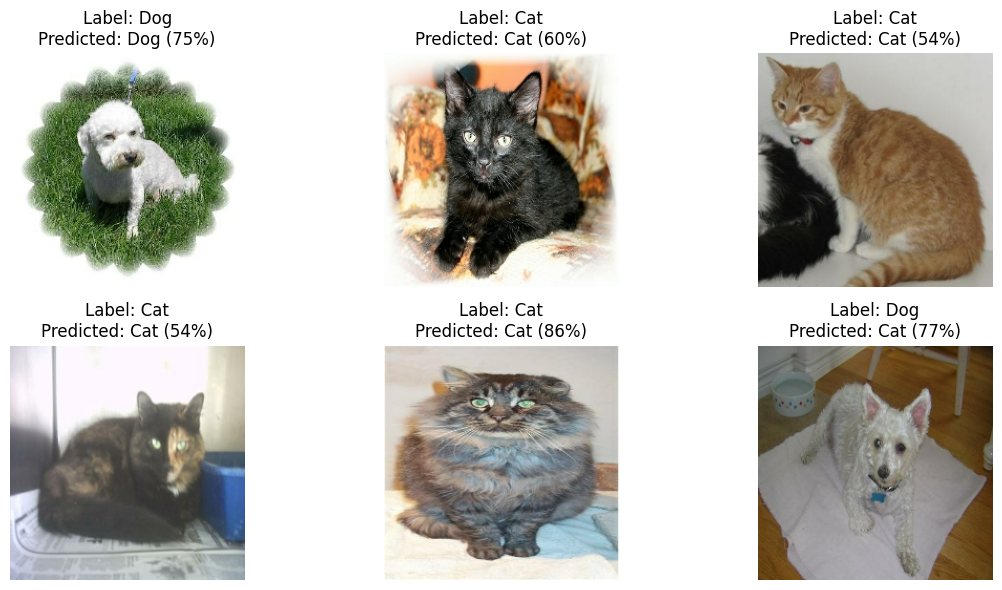

In [ ]:
predict("models/cats_vs_dogs_classifier_15p.keras")

We can see here for our 6 random test case, that 5 out of 6 predictions for our model were correct. Still, the rate of confidence does not overpass 80% of accuracy which is in line with the fit summary we obtained before. Even so, we have a good ratio for a simple model trained with around 2000 images for both classes.

### Model prediction with 50% of dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


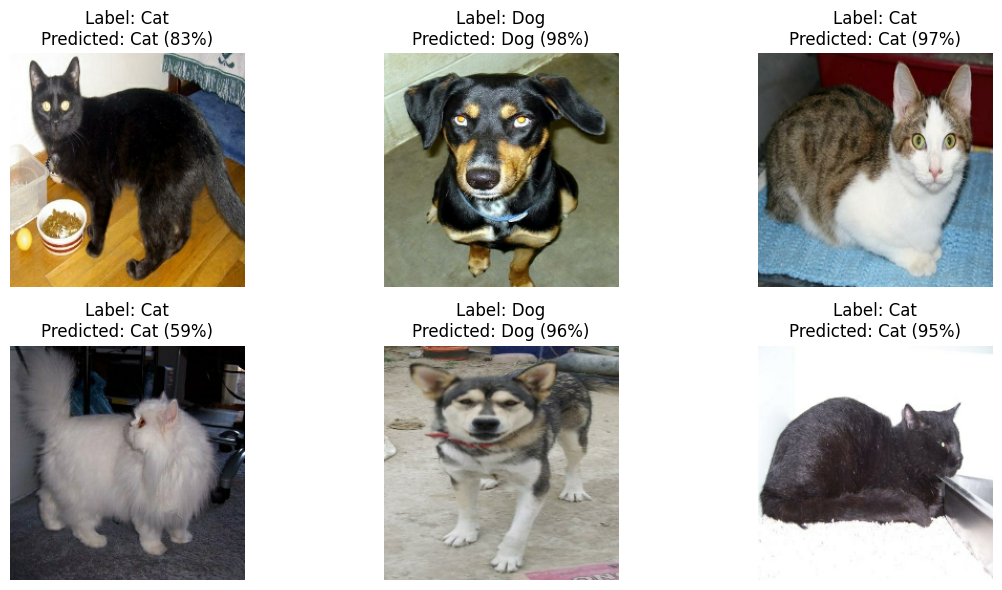

In [ ]:
predict("models/cats_vs_dogs_classifier_50p.keras")

We can see here for our 6 random test case, that all predictions for our model were correct. Additionally, we can remark that the rate of confidence in four of the cases is 95% or more, which evidences that the model is quite sure about his responses for the assigned tasks. This is a very good ratio and accuracy metrics for a model that was trained with only around 10000 images per class.

### Pretrained model predicition with 15% of dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


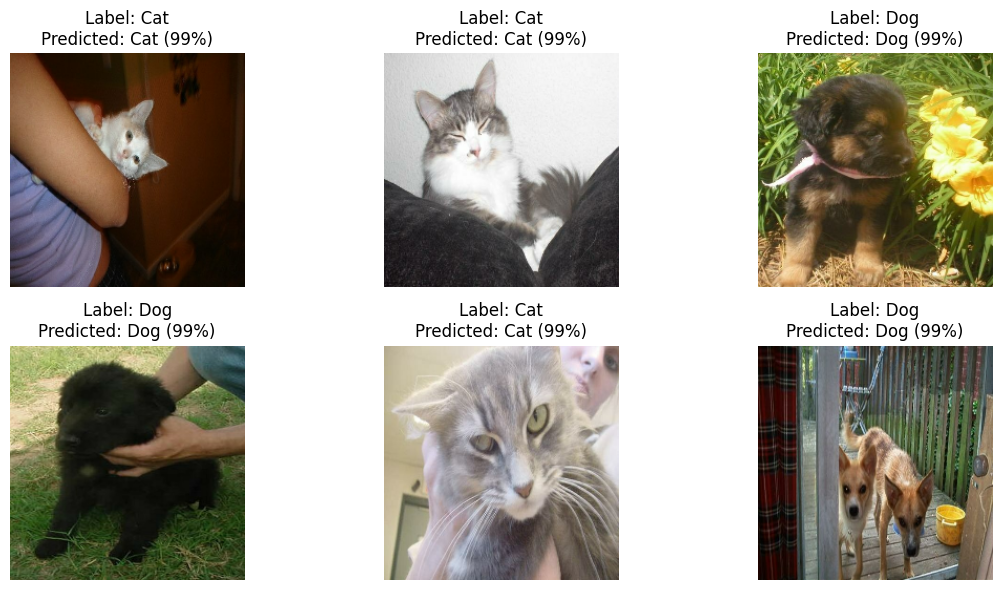

In [ ]:
predict("models/cats_vs_dogs_classifier_15p_mobilnet.keras")

We can see here for our 6 random test case, that all predictions for our model were correct. Furthermore, we can remark that the rate of confidence in all tasks is 99% which demonstrates how confident the model is. By taking into consideration that we have train it with around 2000 images for this specific tasks, the results are very promissing. This let's us conclude that the pretrained neurons are able to quickly reconfigure and detect common patterns in just a few epochs!

## Conclusions

As a final conclusion for this research on ML classification model, we can point out that the usage of pre-trained models, such as **MobileNetV2** used in this notebook, shows a way better results in what concerns performance and time cost to train. Additionally, the model has a payoff overhead for the computational power required to run and the results obtained for the predictions and this can be evidenced in the model summaries. It shows that it is better that the custom models for this task, although we can say that this is not absulutely true as our own model presented a very promising results considering the dataset amount used for training.

## Downloads

Within this notebook we are going to perform a model training with a sample of over 10000 images per class (cat and dog class) depending on the test case scenario. The full dataset can be downloaded for free from the [Dogs and Cats dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

## Bibliography

[What is ML](https://developers.google.com/machine-learning/intro-to-ml/what-is-ml)

[Type of convolutional kernels](https://www.geeksforgeeks.org/deep-learning/types-of-convolution-kernels/)

[Convolutional Neural Network](https://www.mathworks.com/discovery/convolutional-neural-network.html)

[MobileNets: Effecient CNN for Mobile Vision Application](https://arxiv.org/abs/1704.04861)